# Seasonal Stock Prediction

#### This project is not for commercial purpose. All data belong to their rightful owner.

In this exercise, we will predict the price of a seasonal stock through time series forecasting with Facebook's Prophet. A seasonal stock is a type of stock whose price is highly correlated to the consumer demand during a specific time of the year. This is usually a stock from businesses such as airlines and hotel chains. In this notebook, we will attempt to predict the stock price of the former, namely of Air Canada (AC.TO).

## Goal

Evaluate the accuracy of time series forecast with Prophet and suggest adjustements to improve

## Import Libraries

In [192]:
# Import Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from fbprophet import Prophet

# Statsmodels widely known for forecasting than Prophet
import statsmodels.api as sm
from scipy import stats
from pandas.core import datetools
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

# plt.style.available
plt.style.use("seaborn-whitegrid")

#

In [193]:
# Import past 5 years data of AC.TO
df = pd.read_csv('./data/AC.TO.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-13,8.50,8.94,8.50,8.80,8.80,5404352
1,2014-01-14,8.90,8.91,8.65,8.77,8.77,2325574
2,2014-01-15,8.81,8.98,8.67,8.98,8.98,2531051
3,2014-01-16,9.13,9.44,8.91,8.94,8.94,7968768
4,2014-01-17,8.91,9.12,8.65,9.07,9.07,3644323


In [194]:
# Generate description of dataset
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03
mean,15.015992,15.249219,14.784044,15.015880,15.015880,1.702848e+06
std,6.810862,6.909934,6.718780,6.816982,6.816982,1.290316e+06
min,5.250000,5.340000,5.135000,5.160000,5.160000,1.192740e+05
25%,9.440000,9.575000,9.295000,9.430000,9.430000,9.515845e+05
50%,12.500000,12.650000,12.340000,12.510000,12.510000,1.363320e+06
75%,22.895001,23.200000,22.535001,22.910000,22.910000,2.021698e+06
max,29.000000,29.389999,28.750000,29.000000,29.000000,1.502258e+07


In [195]:
# Create a copy to avoid the SettingWarning .loc issue 
acto_df = df.copy()

# Change to datetime datatype
acto_df.loc[:, 'Date'] = pd.to_datetime(acto_df.loc[:,'Date'], format="%Y/%m/%d")

In [196]:
acto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 7 columns):
Date         1255 non-null datetime64[ns]
Open         1255 non-null float64
High         1255 non-null float64
Low          1255 non-null float64
Close        1255 non-null float64
Adj Close    1255 non-null float64
Volume       1255 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.7 KB


In [197]:
# keep the original acto_df
acto_df_original = acto_df.copy()

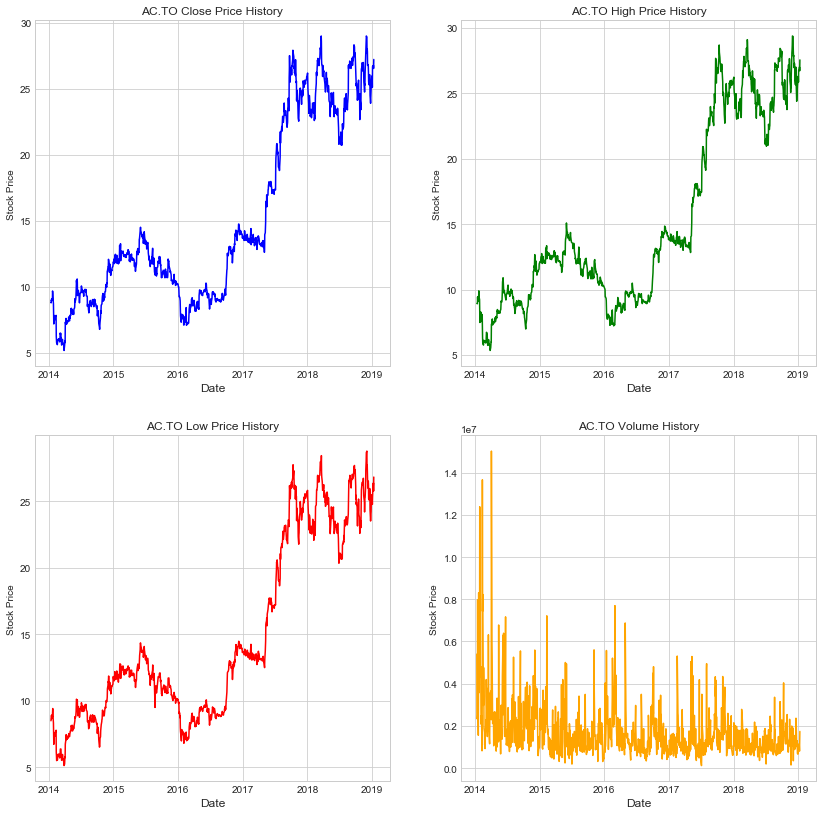

In [198]:
# Plot Air Canada stock price
f, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(14,14))
ax1.plot(acto_df["Date"], acto_df["Close"], color="blue")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("AC.TO Close Price History")

ax2.plot(acto_df["Date"], acto_df["High"], color="green")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("AC.TO High Price History")

ax3.plot(acto_df["Date"], acto_df["Low"], color="red")
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Stock Price")
ax3.set_title("AC.TO Low Price History")

ax4.plot(acto_df["Date"], acto_df["Volume"], color="orange")
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Stock Price")
ax4.set_title("AC.TO Volume History")

plt.show()

We see that there is a lot of fluctuations before 2016. We will thus start by using the data after this date.

In [199]:
acto_df.shape

(1255, 7)

In [200]:
# Remove data before 2016 in acto_df and after 2017
# Make boolean mask
start_date = '2016-01-01'
end_date = '2018-06-30'
mask = (acto_df['Date'] >= start_date) & (acto_df['Date'] <= end_date)

In [201]:
# Reassign sub-df to df
acto_df = acto_df.loc[mask].reset_index()

In [202]:
acto_df.shape

(627, 8)

In [203]:
# drop index axis
acto_df = acto_df.drop(['index'], axis=1)
acto_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,10.100000,10.100000,9.800000,9.950000,9.950000,1623372
1,2016-01-05,10.020000,10.050000,9.900000,9.960000,9.960000,744428
2,2016-01-06,9.870000,9.990000,9.690000,9.700000,9.700000,1217783
3,2016-01-07,9.450000,9.450000,9.030000,9.240000,9.240000,4036006
4,2016-01-08,9.420000,9.450000,9.150000,9.250000,9.250000,1018409
5,2016-01-11,9.300000,9.350000,9.050000,9.180000,9.180000,1797536
6,2016-01-12,9.240000,9.320000,8.730000,9.030000,9.030000,2373718
7,2016-01-13,9.030000,9.140000,8.860000,8.920000,8.920000,2372707
8,2016-01-14,8.530000,8.590000,8.000000,8.160000,8.160000,5573339
9,2016-01-15,7.760000,8.050000,7.690000,7.790000,7.790000,3166296


Why is the first row on 2016-01-04? No data is collected in between (maybe not a business day).

## Use Prophet for Modeling

### Trial 1

In [204]:
# Prepare data for Prophet
# Drop unneccessary columns
ph_df = acto_df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Replace closing price for y and date for ds
ph_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

ph_df.head()

,ds,y
0,2016-01-04,9.95
1,2016-01-05,9.96
2,2016-01-06,9.70
3,2016-01-07,9.24
4,2016-01-08,9.25


In [205]:
ph_df.tail()

,ds,y
622,2018-06-25,22.480000
623,2018-06-26,22.049999
624,2018-06-27,21.180000
625,2018-06-28,20.790001
626,2018-06-29,21.250000


In [206]:
# Create Prophet model
m = Prophet()

# Fit data
m.fit(ph_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [434]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=244)

In [435]:
# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
866,2019-02-24,22.792719,14.505444,30.861227
867,2019-02-25,22.095703,13.734210,30.237522
868,2019-02-26,22.171933,13.516516,30.231096
869,2019-02-27,22.218518,13.648961,30.479844
870,2019-02-28,22.324905,13.557720,30.528172


In [436]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-04,8.773094,7.950026,9.828174,8.773094,8.773094,0.075349,0.075349,0.075349,-0.224775,-0.224775,-0.224775,0.300124,0.300124,0.300124,0.0,0.0,0.0,8.848443
1,2016-01-05,8.744980,7.830995,9.657142,8.744980,8.744980,0.045509,0.045509,0.045509,-0.215122,-0.215122,-0.215122,0.260631,0.260631,0.260631,0.0,0.0,0.0,8.790488
2,2016-01-06,8.716865,7.758750,9.626343,8.716865,8.716865,-0.019609,-0.019609,-0.019609,-0.236260,-0.236260,-0.236260,0.216651,0.216651,0.216651,0.0,0.0,0.0,8.697256
3,2016-01-07,8.688750,7.741853,9.629153,8.688750,8.688750,-0.029910,-0.029910,-0.029910,-0.198485,-0.198485,-0.198485,0.168575,0.168575,0.168575,0.0,0.0,0.0,8.658840
4,2016-01-08,8.660635,7.648758,9.556418,8.660635,8.660635,-0.083437,-0.083437,-0.083437,-0.200325,-0.200325,-0.200325,0.116888,0.116888,0.116888,0.0,0.0,0.0,8.577198


In [437]:
import matplotlib.dates as mdates

In [438]:
# Plot Air Canada stock price

# Make boolean mask 2 to only show the graph of the forcasted dates
start_date_2 = '2018-06-30'
mask2 = (forecast['ds'] >= start_date_2)

In [439]:
forecast_only = forecast[mask2]
forecast_only.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
627,2018-06-30,23.512985,22.230643,24.092666,23.512985,23.512985,-0.357242,-0.357242,-0.357242,0.537483,0.537483,0.537483,-0.894726,-0.894726,-0.894726,0.0,0.0,0.0,23.155743
628,2018-07-01,23.504087,22.221015,24.084419,23.504087,23.504087,-0.338535,-0.338535,-0.338535,0.537483,0.537483,0.537483,-0.876018,-0.876018,-0.876018,0.0,0.0,0.0,23.165552
629,2018-07-02,23.495188,21.459237,23.346121,23.495188,23.495188,-1.078784,-1.078784,-1.078784,-0.224775,-0.224775,-0.224775,-0.854009,-0.854009,-0.854009,0.0,0.0,0.0,22.416404
630,2018-07-03,23.486290,21.565584,23.439972,23.486290,23.486290,-1.044939,-1.044939,-1.044939,-0.215122,-0.215122,-0.215122,-0.829817,-0.829817,-0.829817,0.0,0.0,0.0,22.441351
631,2018-07-04,23.477391,21.571972,23.380120,23.477391,23.477391,-1.040822,-1.040822,-1.040822,-0.236260,-0.236260,-0.236260,-0.804562,-0.804562,-0.804562,0.0,0.0,0.0,22.436570


In [440]:
forecast_only.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
866,2019-02-24,21.386244,14.505444,30.861227,12.928131,29.247784,1.406475,1.406475,1.406475,0.537483,0.537483,0.537483,0.868991,0.868991,0.868991,0.0,0.0,0.0,22.792719
867,2019-02-25,21.377346,13.734210,30.237522,12.861677,29.278061,0.718357,0.718357,0.718357,-0.224775,-0.224775,-0.224775,0.943133,0.943133,0.943133,0.0,0.0,0.0,22.095703
868,2019-02-26,21.368447,13.516516,30.231096,12.796998,29.314459,0.803485,0.803485,0.803485,-0.215122,-0.215122,-0.215122,1.018607,1.018607,1.018607,0.0,0.0,0.0,22.171933
869,2019-02-27,21.359549,13.648961,30.479844,12.735047,29.346615,0.858970,0.858970,0.858970,-0.236260,-0.236260,-0.236260,1.095229,1.095229,1.095229,0.0,0.0,0.0,22.218518
870,2019-02-28,21.350650,13.557720,30.528172,12.688042,29.395244,0.974254,0.974254,0.974254,-0.198485,-0.198485,-0.198485,1.172739,1.172739,1.172739,0.0,0.0,0.0,22.324905


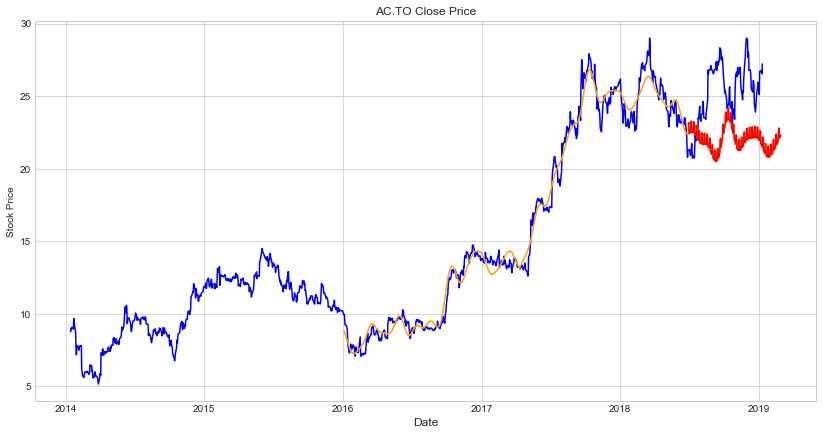

In [441]:
# actual price (blue)
f, (ax1) = plt.subplots(1, 1, figsize=(14,7))
ax1.plot(acto_df_original["Date"], acto_df_original["Close"], color="blue")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("AC.TO Close Price")

# train price and forecast price (orange)
ax1.plot(forecast["ds"], forecast["yhat"], color="orange")
ax1.set_xlabel("Date", fontsize=12)

# forecast price only (red)
ax1.plot(forecast_only["ds"], forecast_only["yhat"], color="red")
ax1.set_xlabel("Date", fontsize=12)

plt.show()

The forecast line (in red) seems to fit the actual price line (blue) well until around mid-2018. This is probably due to the sudden trough around this period of time. According to the news around the summer of 2018, the price dropped due to economic headwinds. For more information: https://www.fool.ca/2018/06/28/2-reasons-to-avoid-airlines-as-economic-headwinds-build-up/ 

Since headwinds are extrinsic phenomena that affect Air Canada, it is expected for the model to make a relatively inaccurate prediction. We will try excluding the anomaly by setting the maximum of our training set's domain to 2018-05-31, inclusively.

### Trial 2 (with data before anomaly)

In [215]:
# Create new acto df without the anomaly
acto_df_adj = acto_df_original.copy()

# Make boolean mask
start_date_adj = '2016-01-01'
end_date_adj = '2018-05-31'
mask_adj = (acto_df_adj['Date'] >= start_date_adj) & (acto_df_adj['Date'] <= end_date_adj)

# Reassign sub-df to df
acto_df_adj = acto_df_adj.loc[mask_adj].reset_index()

In [216]:
acto_df_adj.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,495,2016-01-04,10.10,10.10,9.80,9.95,9.95,1623372
1,496,2016-01-05,10.02,10.05,9.90,9.96,9.96,744428
2,497,2016-01-06,9.87,9.99,9.69,9.70,9.70,1217783
3,498,2016-01-07,9.45,9.45,9.03,9.24,9.24,4036006
4,499,2016-01-08,9.42,9.45,9.15,9.25,9.25,1018409


In [217]:
acto_df_adj.tail()

,index,Date,Open,High,Low,Close,Adj Close,Volume
601,1096,2018-05-25,24.250000,24.920000,24.219999,24.469999,24.469999,990384
602,1097,2018-05-28,24.549999,24.870001,24.549999,24.719999,24.719999,360735
603,1098,2018-05-29,24.459999,24.549999,23.469999,23.900000,23.900000,1378225
604,1099,2018-05-30,23.959999,23.990000,23.440001,23.540001,23.540001,1240851
605,1100,2018-05-31,23.240000,23.680000,22.910000,22.969999,22.969999,1386284


In [218]:
# Prepare data for Prophet
# Drop unneccessary columns
ph_df_adj = acto_df_adj.drop(['index', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Replace closing price for y and date for ds
ph_df_adj.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

ph_df_adj.head()

,ds,y
0,2016-01-04,9.95
1,2016-01-05,9.96
2,2016-01-06,9.70
3,2016-01-07,9.24
4,2016-01-08,9.25


In [219]:
# Create Prophet model
m_adj = Prophet()

# Fit data
m_adj.fit(ph_df_adj)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [424]:
# Create Future dates
future_prices_adj = m_adj.make_future_dataframe(periods=273)

In [425]:
# Predict Prices
forecast_adj = m_adj.predict(future_prices_adj)
forecast_adj[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
874,2019-02-24,26.467628,19.124566,33.606348
875,2019-02-25,25.458353,18.322406,32.605577
876,2019-02-26,25.523601,18.653955,32.894751
877,2019-02-27,25.561458,18.187331,32.699664
878,2019-02-28,25.667276,18.660786,32.956317


In [426]:
# Plot Air Canada stock price with adjustment

# Make boolean mask 2 adjusted to only show the graph of the forcasted dates
start_date_2_adj = '2018-06-01'
mask2_adj = (forecast_adj['ds'] >= start_date_2_adj)

In [427]:
forecast_only_adj = forecast_adj[mask2_adj]

In [428]:
forecast_only.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
627,2018-06-30,23.512985,22.167175,24.084503,23.512985,23.512985,-0.357242,-0.357242,-0.357242,0.537483,0.537483,0.537483,-0.894726,-0.894726,-0.894726,0.0,0.0,0.0,23.155743
628,2018-07-01,23.504087,22.262248,24.128181,23.504087,23.504087,-0.338535,-0.338535,-0.338535,0.537483,0.537483,0.537483,-0.876018,-0.876018,-0.876018,0.0,0.0,0.0,23.165552
629,2018-07-02,23.495188,21.483610,23.317209,23.495188,23.495188,-1.078784,-1.078784,-1.078784,-0.224775,-0.224775,-0.224775,-0.854009,-0.854009,-0.854009,0.0,0.0,0.0,22.416404
630,2018-07-03,23.486290,21.480956,23.375234,23.486290,23.486290,-1.044939,-1.044939,-1.044939,-0.215122,-0.215122,-0.215122,-0.829817,-0.829817,-0.829817,0.0,0.0,0.0,22.441351
631,2018-07-04,23.477391,21.497379,23.401983,23.477391,23.477391,-1.040822,-1.040822,-1.040822,-0.236260,-0.236260,-0.236260,-0.804562,-0.804562,-0.804562,0.0,0.0,0.0,22.436570


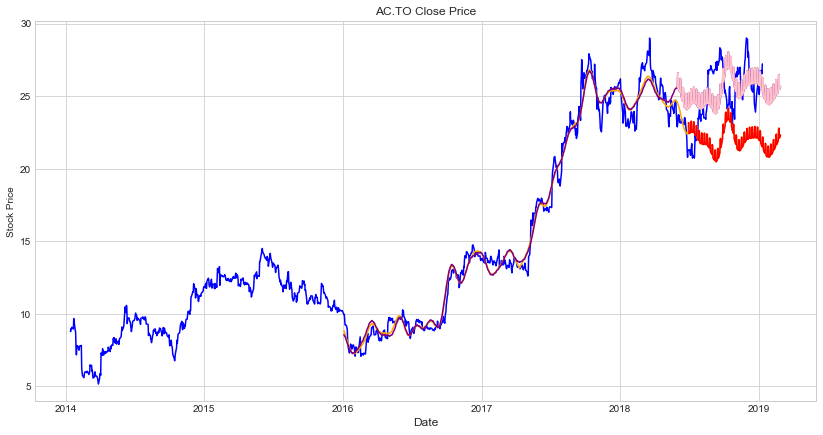

In [442]:
# actual price (blue)
f, (ax1) = plt.subplots(1, 1, figsize=(14,7))
ax1.plot(acto_df_original["Date"], acto_df_original["Close"], color="blue")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("AC.TO Close Price")

# train price and forecast price (orange)
ax1.plot(forecast["ds"], forecast["yhat"], color="orange")
ax1.set_xlabel("Date", fontsize=12)

# train price and adjusted forecast price (purple)
ax1.plot(forecast_adj["ds"], forecast_adj["yhat"], color="purple")
ax1.set_xlabel("Date", fontsize=12)

# forecast price only (red)
ax1.plot(forecast_only["ds"], forecast_only["yhat"], color="red")
ax1.set_xlabel("Date", fontsize=12)

# adjusted forecast price only (pink)
ax1.plot(forecast_only_adj["ds"], forecast_only_adj["yhat"], color="pink")
ax1.set_xlabel("Date", fontsize=12)

plt.show()

By starting the forecast earlier (pink), the predicted trend seems closer to the actual trend (blue). Analyzing the trendlines, we can observe that the predicted trendline is more accurate closer to the dates of the training data. Thus, we will next try to make our prediction more accurate by taking out the anomaly and also using data after it to train our model. By doing, we obtain more training data that is closer to our current date.

### Trial 3 (with data excluding the anomaly)

In [445]:
# Create new acto df without the anomaly
acto_df_adj_excl = acto_df_original.copy()

# Make boolean mask
# Dates before anomaly
start_date_adj_excl_1 = '2016-01-01'
end_date_adj_excl_1 = '2018-05-31'

# Dates after anomaly
start_date_adj_excl_2 = '2018-09-01'
end_date_adj_excl_2 = '2018-11-30'

mask_adj_excl_1 = (acto_df_adj_excl['Date'] >= start_date_adj_excl_1) & (acto_df_adj_excl['Date'] <= end_date_adj_excl_1)

In [446]:
acto_df_adj_excl_1 = acto_df_adj_excl.loc[mask_adj_excl_1].reset_index()

In [447]:
acto_df_adj_excl_1.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,495,2016-01-04,10.10,10.10,9.80,9.95,9.95,1623372
1,496,2016-01-05,10.02,10.05,9.90,9.96,9.96,744428
2,497,2016-01-06,9.87,9.99,9.69,9.70,9.70,1217783
3,498,2016-01-07,9.45,9.45,9.03,9.24,9.24,4036006
4,499,2016-01-08,9.42,9.45,9.15,9.25,9.25,1018409


In [448]:
acto_df_adj_excl_1.tail()

,index,Date,Open,High,Low,Close,Adj Close,Volume
601,1096,2018-05-25,24.250000,24.920000,24.219999,24.469999,24.469999,990384
602,1097,2018-05-28,24.549999,24.870001,24.549999,24.719999,24.719999,360735
603,1098,2018-05-29,24.459999,24.549999,23.469999,23.900000,23.900000,1378225
604,1099,2018-05-30,23.959999,23.990000,23.440001,23.540001,23.540001,1240851
605,1100,2018-05-31,23.240000,23.680000,22.910000,22.969999,22.969999,1386284


In [449]:
acto_df_adj_excl_1.shape

(606, 8)

In [450]:
mask_adj_excl_2 = (acto_df_adj_excl['Date'] >= start_date_adj_excl_2) & (acto_df_adj_excl['Date'] <= end_date_adj_excl_2)

In [451]:
acto_df_adj_excl_2 = acto_df_adj_excl.loc[mask_adj_excl_2].reset_index()

In [452]:
acto_df_adj_excl_2.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,1165,2018-09-04,26.809999,26.940001,26.120001,26.540001,26.540001,956319
1,1166,2018-09-05,26.400000,26.690001,25.980000,26.580000,26.580000,1152208
2,1167,2018-09-06,26.590000,27.100000,26.410000,26.760000,26.760000,940502
3,1168,2018-09-07,26.730000,27.020000,26.639999,26.830000,26.830000,657781
4,1169,2018-09-10,26.809999,26.990000,26.670000,26.830000,26.830000,745521


In [453]:
acto_df_adj_excl_2.tail()

,index,Date,Open,High,Low,Close,Adj Close,Volume
58,1223,2018-11-26,26.200001,27.760000,26.090000,27.41,27.41,1992462
59,1224,2018-11-27,27.350000,28.139999,27.350000,27.60,27.60,1480842
60,1225,2018-11-28,28.000000,28.340000,27.670000,28.24,28.24,1590530
61,1226,2018-11-29,28.139999,28.695000,28.000000,28.65,28.65,1055756
62,1227,2018-11-30,28.650000,29.389999,28.639999,29.00,29.00,1417922


In [454]:
acto_df_adj_excl_2.shape

(63, 8)

In [455]:
acto_df_adj_excl = pd.concat([acto_df_adj_excl_1, acto_df_adj_excl_2]).reset_index()

In [456]:
acto_df_adj_excl.shape

(669, 9)

In [457]:
acto_df_adj_excl.tail()

,level_0,index,Date,Open,High,Low,Close,Adj Close,Volume
664,58,1223,2018-11-26,26.200001,27.760000,26.090000,27.41,27.41,1992462
665,59,1224,2018-11-27,27.350000,28.139999,27.350000,27.60,27.60,1480842
666,60,1225,2018-11-28,28.000000,28.340000,27.670000,28.24,28.24,1590530
667,61,1226,2018-11-29,28.139999,28.695000,28.000000,28.65,28.65,1055756
668,62,1227,2018-11-30,28.650000,29.389999,28.639999,29.00,29.00,1417922


In [458]:
# Prepare data for Prophet
# Drop unneccessary columns
ph_df_adj_excl = acto_df_adj_excl.drop(['level_0', 'index', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Replace closing price for y and date for ds
ph_df_adj_excl.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

ph_df_adj_excl.head()

,ds,y
0,2016-01-04,9.95
1,2016-01-05,9.96
2,2016-01-06,9.70
3,2016-01-07,9.24
4,2016-01-08,9.25


In [459]:
ph_df_adj_excl.shape

(669, 2)

In [460]:
ph_df_adj_excl.tail()

,ds,y
664,2018-11-26,27.41
665,2018-11-27,27.60
666,2018-11-28,28.24
667,2018-11-29,28.65
668,2018-11-30,29.00


In [472]:
# Create Prophet model
m_adj_excl = Prophet()

# Fit data
m_adj_excl.fit(ph_df_adj_excl)

# Create future dates
future_prices_adj_excl = m_adj_excl.make_future_dataframe(periods=90)

# Predict prices
forecast_adj_excl = m_adj_excl.predict(future_prices_adj_excl)
forecast_adj_excl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
754,2019-02-24,26.257689,24.613482,27.782449
755,2019-02-25,25.233180,23.752540,26.851976
756,2019-02-26,25.296860,23.936561,26.805888
757,2019-02-27,25.327589,23.767580,26.938582
758,2019-02-28,25.413245,23.940641,27.019248


In [473]:
# Plot Air Canada stock price with adjustment

# Make boolean mask to only show the graph of the forcasted dates
start_date_2_adj_excl = '2018-12-01'
mask2_adj_excl = (forecast_adj_excl['ds'] >= start_date_2_adj_excl)

In [474]:
forecast_only_adj_excl = forecast_adj_excl[mask2_adj_excl]

In [475]:
forecast_only_adj_excl.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
669,2018-12-01,25.766061,26.331924,28.959639,25.766061,25.766061,1.922906,1.922906,1.922906,0.745913,0.745913,0.745913,1.176993,1.176993,1.176993,0.0,0.0,0.0,27.688967
670,2018-12-02,25.766496,26.301533,29.135486,25.766496,25.766496,1.948200,1.948200,1.948200,0.745913,0.745913,0.745913,1.202287,1.202287,1.202287,0.0,0.0,0.0,27.714696
671,2018-12-03,25.766931,25.365896,28.119765,25.766931,25.766931,0.900195,0.900195,0.900195,-0.323205,-0.323205,-0.323205,1.223400,1.223400,1.223400,0.0,0.0,0.0,26.667126
672,2018-12-04,25.767365,25.331175,28.015564,25.767365,25.767365,0.934311,0.934311,0.934311,-0.306027,-0.306027,-0.306027,1.240337,1.240337,1.240337,0.0,0.0,0.0,26.701676
673,2018-12-05,25.767800,25.476712,27.990994,25.767800,25.767800,0.929520,0.929520,0.929520,-0.323658,-0.323658,-0.323658,1.253178,1.253178,1.253178,0.0,0.0,0.0,26.697320


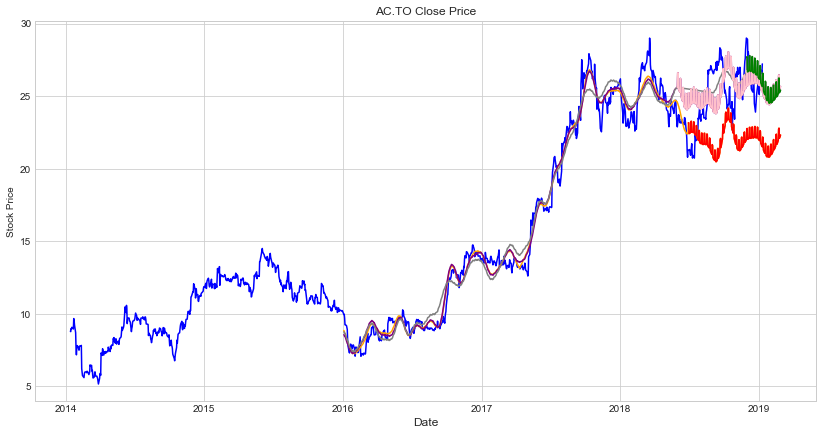

In [476]:
# actual price (blue)
f, (ax1) = plt.subplots(1, 1, figsize=(14,7))
ax1.plot(acto_df_original["Date"], acto_df_original["Close"], color="blue")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("AC.TO Close Price")

# train price and forecast price (orange)
ax1.plot(forecast["ds"], forecast["yhat"], color="orange")
ax1.set_xlabel("Date", fontsize=12)

# train price and adjusted forecast price (purple)
ax1.plot(forecast_adj["ds"], forecast_adj["yhat"], color="purple")
ax1.set_xlabel("Date", fontsize=12)

# train price and adjusted forecast price excluding anomaly (gray)
ax1.plot(forecast_adj_excl["ds"], forecast_adj_excl["yhat"], color="gray")
ax1.set_xlabel("Date", fontsize=12)

# forecast price only (red)
ax1.plot(forecast_only["ds"], forecast_only["yhat"], color="red")
ax1.set_xlabel("Date", fontsize=12)

# adjusted forecast price only (pink)
ax1.plot(forecast_only_adj["ds"], forecast_only_adj["yhat"], color="pink")
ax1.set_xlabel("Date", fontsize=12)

# adjusted forecast price excluding anomaly only (green)
ax1.plot(forecast_only_adj_excl["ds"], forecast_only_adj_excl["yhat"], color="green")
ax1.set_xlabel("Date", fontsize=12)

plt.show()

#### Trial 3 result only

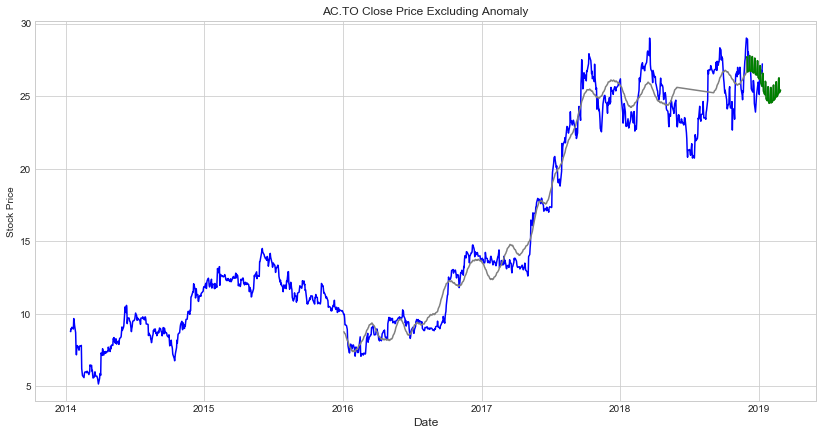

In [477]:
# actual price (blue)
f, (ax1) = plt.subplots(1, 1, figsize=(14,7))
ax1.plot(acto_df_original["Date"], acto_df_original["Close"], color="blue")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("AC.TO Close Price Excluding Anomaly")

# train price and adjusted forecast price excluding anomaly (gray)
ax1.plot(forecast_adj_excl["ds"], forecast_adj_excl["yhat"], color="gray")
ax1.set_xlabel("Date", fontsize=12)

# adjusted forecast price excluding anomaly only (green)
ax1.plot(forecast_only_adj_excl["ds"], forecast_only_adj_excl["yhat"], color="green")
ax1.set_xlabel("Date", fontsize=12)

plt.show()

The new trendline (green) seems accurate. For instance, near the end of 2018, the green trendline predicts a higher price than the trendlines from the previous trials. This new prediction is closer to the actual price.

## Analysis

The prediction seems more accurate with more recent training data and without anomalies. It seems most accurate for a period less than a month of prediction.

Despite their differences in prices, the trendlines follow similar patterns. They all fall at the beginning of 2019 and rises later. If we look at the actual data from the previous years (blue), we notice that the stock prices usually falls at the beginning of the year and rises until summer. This can be explained by the fact that consumers return from winter break at the beginning of the year, have less time to travel, and thus use Air Canada's service. With less demand and revenue, the stock price falls. However, toward summer, due to the weather and more leisure time (especially for families with members attending school), consumers travel more often and the demand for Air Canada's service rises. With more revenue, the stock price rises.

## Conclusion

Time series forecasting with Prophet predicts relatively accurately the general trend of a seasonal stock's price during a year. However, it is vulnerable to anomalies caused by extrinsic macroeconomic factors. It is thus recommended to remove these anomalies from the training data. The prediction is also less accurate for long periods of time (more than a month). Apart from seasonality, many factors lead to fluctuations in a seasonal stocks' price. This explains the difficulty in making an accurate prediction. It is thus recommended to only pay close attention to the predicted prices closer to the dates of the training data.

Adjustements to improve the model require a deeper understanding of macroeconomy and the stock market. This knowledge can be used to improve the current model, for instance by changing the criteria for the training data set, or to combine the current model with other machine learning algorithms, such as for language processing. A thorough analysis of stock sentiment from news and social media can possibly improve the accuracy of the current model.

## Resources

What is a seasonal stock? https://www.timothysykes.com/blog/seasonal-stocks/

Yahoo Finance: https://finance.yahoo.com/quote/AC.TO/history?p=AC.TO&.tsrc=fin-srch

Prophet: https://research.fb.com/prophet-forecasting-at-scale/